# Лабораторная работа №4
Выполнил: Урлов Егор Сергеевич
План работы:
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). 
     2. Проверить пропуски в данных. 
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` , а затем засунуть в `Dataloader`.
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD`.
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam`.
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam`.
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах (MAE)
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?



## 1. Импорт данных.

In [2]:
import pandas as pd

path_to_dataset = './marketing_campaign.csv'
df = pd.read_csv(path_to_dataset, sep = '\t')
df = df.dropna()
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## 2 Предобработка данных

### Разделение выборки на тренировочную (train) и тестовую (test)

Разделение выборки на тренировочную и тестовую позволяет оценить производительность модели на новых, ранее не виденных данных. Это важно для проверки обобщающей способности модели и предотвращения переобучения. Переобучение возникает, когда модель хорошо работает на тренировочных данных, но плохо обобщается на новые данные. В Python, для разделения выборки на тренировочную и тестовую можно использовать функцию train_test_split из библиотеки scikit-learn. Эта функция случайным образом разбивает данные на две части с заданным соотношением. Обычно принято использовать пропорцию 70-80% для тренировочной выборки и 20-30% для тестовой выборки.

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Income', 'Dt_Customer']) 
y = df['Income'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Размерность тренировочной выборки X_train:", X_train.shape)
print("Размерность тестовой выборки X_test:", X_test.shape)
print("Размерность тренировочной выборки y_train:", y_train.shape)
print("Размерность тестовой выборки y_test:", y_test.shape)
print("y_train: ")
print(y_train)
print("y_test: ")
print(y_test)

Размерность тренировочной выборки X_train: (1772, 27)
Размерность тестовой выборки X_test: (444, 27)
Размерность тренировочной выборки y_train: (1772,)
Размерность тестовой выборки y_test: (444,)
y_train: 
209     64497.0
53      82582.0
184     28249.0
2115    66476.0
728     56962.0
         ...   
1655    35544.0
1108    65463.0
1143    33419.0
1307    81051.0
873     42395.0
Name: Income, Length: 1772, dtype: float64
y_test: 
961     52597.0
229     34320.0
1093    38578.0
427     75433.0
1650    22448.0
         ...   
24      40689.0
1907    33235.0
440     28691.0
1794    34074.0
2033    55914.0
Name: Income, Length: 444, dtype: float64


### Отнормирование численных переменных

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Создание копии данных для масштабирования
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Применение Label Encoding к категориальным переменным
label_encoder = LabelEncoder()
for column in X_train.select_dtypes(include=['object']).columns:
    X_train_encoded[column] = label_encoder.fit_transform(X_train[column])
    X_test_encoded[column] = label_encoder.transform(X_test[column])

# Инициализация и применение StandardScaler
scaler = StandardScaler()
X_train_standart_scaled = scaler.fit_transform(X_train_encoded)
X_test_standart_scaled = scaler.transform(X_test_encoded)
print("X_train_standart_scaled: ")
print(X_train_standart_scaled)
print("")

# Инициализация и применение MinMaxScaler
scaler = MinMaxScaler()
X_train_minmax_scaled = scaler.fit_transform(X_train_encoded)
X_test_minmax_scaled = scaler.transform(X_test_encoded)
print("X_train_minmax_scaled: ")
print(X_train_minmax_scaled)


X_train_standart_scaled: 
[[-1.61965472 -1.20028617 -0.36192427 ...  0.          0.
   2.35345393]
 [-1.05058901  0.69344498 -0.36192427 ...  0.          0.
   2.35345393]
 [-0.94633741 -0.62393321 -1.25019269 ...  0.          0.
  -0.4249074 ]
 ...
 [ 0.85832572 -0.54159707  1.41461258 ...  0.          0.
  -0.4249074 ]
 [-0.38158981 -0.29458866  1.41461258 ...  0.          0.
  -0.4249074 ]
 [-1.50923438  1.02278953 -2.13846112 ...  0.          0.
  -0.4249074 ]]

X_train_minmax_scaled: 
[[0.03283235 0.59223301 0.5        ... 0.         0.         1.        ]
 [0.19788871 0.81553398 0.5        ... 0.         0.         1.        ]
 [0.22812668 0.66019417 0.25       ... 0.         0.         0.        ]
 ...
 [0.75156558 0.66990291 1.         ... 0.         0.         0.        ]
 [0.39193058 0.69902913 1.         ... 0.         0.         0.        ]
 [0.06485955 0.85436893 0.         ... 0.         0.         0.        ]]


###  Кодировка категориальных признаков
При работе с категориальными признаками в машинном обучении, часто нужно преобразовать их в числовой формат, потому что многие алгоритмы машинного обучения требуют числовых данных для работы.х.

In [5]:
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
X_train_one_hot_encoded = one_hot_encoder.fit_transform(X_train)
X_test_one_hot_encoded = one_hot_encoder.transform(X_test)
print("X_train_one_hot_encoded: ")
print(X_train_one_hot_encoded.toarray())
print("")
print("X_test_one_hot_encoded: ")
print(X_test_one_hot_encoded.toarray())
print("")


X_train_one_hot_encoded: 
[[0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]]

X_test_one_hot_encoded: 
[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]]



## 3. Оформление данных в виде класса Dataset и помещение в Dataloader
Для оформления данных тренировочной и тестовой выборок в виде класса Dataset из библиотеки PyTorch и последующего использования с помощью DataLoader потребуется создать подкласс torch.utils.data.Dataset и переопределить методы __init__, __len__ и __getitem__.

In [43]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)  # Преобразуем разреженную матрицу в плотную
        self.y = torch.tensor(y, dtype=torch.float32) 
    
    def __len__(self):
        return len(self.X) 
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]  # Возвращаем признаки и соответствующую целевую переменную по индексу

# Создание экземпляров тренировочной и тестовой выборок
train_dataset = MyDataset(X_train_one_hot_encoded, X_train_minmax_scaled)
test_dataset = MyDataset(X_test_one_hot_encoded, X_test_minmax_scaled)

# Создание DataLoader для тренировочной и тестовой выборок
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## 4 Обучение на тренировочном множестве 

### Обучение простой однослойной нейросети с оптимизатором SGD

In [44]:
# Определение класса модели
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)  # Однослойный линейный слой
        
    def forward(self, x):
        x = self.fc(x)
        return x

# Определение параметров модели
input_size = X_train_one_hot_encoded.shape[1]  # Размерность входных данных
output_size = 1  # Размерность выходных данных (в нашем случае один выход)
learning_rate = 0.01

# Создание экземпляра модели
model_SimpleNet = SimpleNet(input_size, output_size)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.SGD(model_SimpleNet.parameters(), lr=learning_rate)

# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    model_SimpleNet.train()  # Установка модели в режим обучения
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Прямой проход
        outputs = model_SimpleNet(inputs)
        loss = criterion(outputs, labels)
        
        # Обратное распространение и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Эпоха {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")

print("Обучение завершено")

Эпоха 1/10, Loss: 0.44211230576038363
Эпоха 2/10, Loss: 0.20235050320625306
Эпоха 3/10, Loss: 0.19527994096279144
Эпоха 4/10, Loss: 0.19407792687416076
Эпоха 5/10, Loss: 0.19275111556053162
Эпоха 6/10, Loss: 0.19175440669059754
Эпоха 7/10, Loss: 0.19056629836559297
Эпоха 8/10, Loss: 0.189671790599823
Эпоха 9/10, Loss: 0.18897153437137604
Эпоха 10/10, Loss: 0.1879392832517624
Обучение завершено


C:\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 30])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([60, 30])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### Обучение на тренировочном множестве нейросети посложнее (с 1 скрытым слоем) с оптимизатором Adam

In [45]:
# Определение нейросети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Параметры нейросети
input_size = X_train_one_hot_encoded.shape[1]
hidden_size = 64  # Размер скрытого слоя
output_size = 1  # Размер выходного слоя

# Создание нейросети
model_NeuralNetwork = NeuralNetwork(input_size, hidden_size, output_size)

# Оптимизатор
learning_rate = 0.001
optimizer = optim.Adam(model_NeuralNetwork.parameters(), lr=learning_rate)

# Функция потерь
criterion = nn.MSELoss()

# Обучение нейросети
num_epochs = 100
for epoch in range(num_epochs):
    # Переводим модель в режим обучения
    model_NeuralNetwork.train()
    
    # Проходим по каждому батчу в тренировочном датасете
    for inputs, targets in train_dataloader:
        # Обнуляем градиент
        optimizer.zero_grad()
        
        # Передаем данные через нейросеть
        outputs = model_NeuralNetwork(inputs)
        
        # Вычисляем функцию потерь
        loss = criterion(outputs, targets)
        
        # Рассчитываем градиенты
        loss.backward()
        
        # Обновляем параметры модели
        optimizer.step()

    # Выводим промежуточные результаты
    if (epoch+1) % 10 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Обучение завершено")

Эпоха [10/100], Loss: 0.1758
Эпоха [20/100], Loss: 0.1729
Эпоха [30/100], Loss: 0.1715
Эпоха [40/100], Loss: 0.1698
Эпоха [50/100], Loss: 0.1744
Эпоха [60/100], Loss: 0.1728
Эпоха [70/100], Loss: 0.1726
Эпоха [80/100], Loss: 0.1751
Эпоха [90/100], Loss: 0.1720
Эпоха [100/100], Loss: 0.1738
Обучение завершено


### Обучение на тренировочном множестве нейросети еще сложнее (с 3+ скрытыми слоями) с оптимизатором Adam

In [26]:
# Определение нейросети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Параметры нейросети
input_size = X_train_one_hot_encoded.shape[1]
hidden_sizes = [64, 32, 16]  # Размеры скрытых слоев
output_size = 1  # Размер выходного слоя

# Создание нейросети
model_HardNeuralNetwork = NeuralNetwork(input_size, hidden_sizes, output_size)

# Оптимизатор
learning_rate = 0.001
optimizer = optim.Adam(model_HardNeuralNetwork.parameters(), lr=learning_rate)

# Функция потерь
criterion = nn.MSELoss()

# Обучение нейросети
num_epochs = 100
for epoch in range(num_epochs):
    # Переводим модель в режим обучения
    model_HardNeuralNetwork.train()
    
    # Проходим по каждому батчу в тренировочном датасете
    for inputs, targets in train_dataloader:
        # Обнуляем градиент
        optimizer.zero_grad()
        
        # Передаем данные через нейросеть
        outputs = model_HardNeuralNetwork(inputs)
        
        # Вычисляем функцию потерь
        loss = criterion(outputs, targets)
        
        # Рассчитываем градиенты
        loss.backward()
        
        # Обновляем параметры модели
        optimizer.step()

    # Выводим промежуточные результаты
    if (epoch+1) % 10 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Эпоха [10/100], Loss: 0.1733
Эпоха [20/100], Loss: 0.1740
Эпоха [30/100], Loss: 0.1735
Эпоха [40/100], Loss: 0.1721
Эпоха [50/100], Loss: 0.1692
Эпоха [60/100], Loss: 0.1750
Эпоха [70/100], Loss: 0.1717
Эпоха [80/100], Loss: 0.1716
Эпоха [90/100], Loss: 0.1710
Эпоха [100/100], Loss: 0.1711


## 5 Подсчет loss на train и test множествах, в зависимости от эпохи обучения. Визуализация результата с помощью библиотеки matplotlib (выйдет так называемая learning curve, кривая обучения модели)

Эпоха [1/100], Обучающий Loss: 0.3711, Тестовый Loss: 0.3354
Эпоха [2/100], Обучающий Loss: 0.3091, Тестовый Loss: 0.2728
Эпоха [3/100], Обучающий Loss: 0.2438, Тестовый Loss: 0.2088
Эпоха [4/100], Обучающий Loss: 0.1911, Тестовый Loss: 0.1789
Эпоха [5/100], Обучающий Loss: 0.1826, Тестовый Loss: 0.1910
Эпоха [6/100], Обучающий Loss: 0.1866, Тестовый Loss: 0.1812
Эпоха [7/100], Обучающий Loss: 0.1770, Тестовый Loss: 0.1781
Эпоха [8/100], Обучающий Loss: 0.1769, Тестовый Loss: 0.1799
Эпоха [9/100], Обучающий Loss: 0.1773, Тестовый Loss: 0.1782
Эпоха [10/100], Обучающий Loss: 0.1753, Тестовый Loss: 0.1766
Эпоха [11/100], Обучающий Loss: 0.1746, Тестовый Loss: 0.1767
Эпоха [12/100], Обучающий Loss: 0.1746, Тестовый Loss: 0.1762
Эпоха [13/100], Обучающий Loss: 0.1738, Тестовый Loss: 0.1758
Эпоха [14/100], Обучающий Loss: 0.1736, Тестовый Loss: 0.1757
Эпоха [15/100], Обучающий Loss: 0.1734, Тестовый Loss: 0.1754
Эпоха [16/100], Обучающий Loss: 0.1731, Тестовый Loss: 0.1751
Эпоха [17/100], О

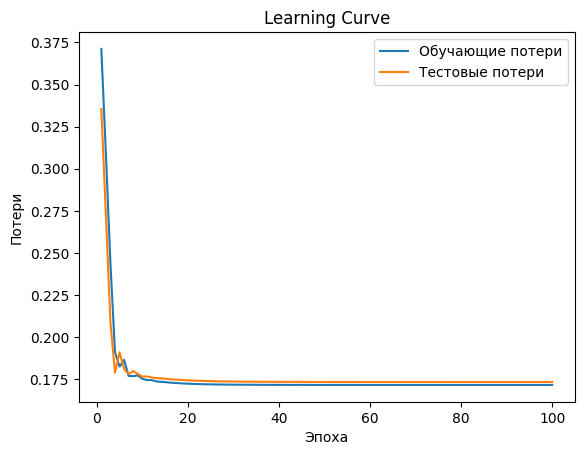

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Определение нейросети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

# Функция для обучения модели и визуализации learning curve
def train_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # Переводим модель в режим обучения
        model.train()
        
        # Обучение на тренировочном наборе данных
        train_loss = 0.0
        for inputs, targets in train_dataloader:
            
            # Обнуляем градиент
            optimizer.zero_grad()
            # Передаем данные через нейросеть
            outputs = model(inputs)
            # Вычисляем функцию потерь
            loss = criterion(outputs, targets)
            train_loss += loss.item() * inputs.size(0)   
            # Рассчитываем градиенты
            loss.backward()
            # Обновляем параметры модели
            optimizer.step()
        
        # Сохраняем значение loss для обучающего набора данных
        train_loss = train_loss / len(train_dataloader.dataset)
        train_losses.append(train_loss)

        # Оценка loss на тестовом наборе данных
        model.eval()
        test_loss = 0.0
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
        test_loss = test_loss / len(test_dataloader.dataset)
        test_losses.append(test_loss)
        
        # Выводим результаты обучения на каждой эпохе
        print(f'Эпоха [{epoch+1}/{num_epochs}], Обучающий Loss: {train_loss:.4f}, Тестовый Loss: {test_loss:.4f}')

    # Визуализация learning curve
    plt.plot(range(1, num_epochs+1), train_losses, label='Обучающие потери')
    plt.plot(range(1, num_epochs+1), test_losses, label='Тестовые потери')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

# Параметры нейросети
input_size = X_train_one_hot_encoded.shape[1]
hidden_sizes = [64, 32, 16]  # Размеры скрытых слоев
output_size = 1  # Размер выходного слоя

# Создание нейросети
model = NeuralNetwork(input_size, hidden_sizes, output_size)

# Оптимизатор
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Функция потерь
criterion = nn.MSELoss()

# Обучение нейросети и визуализация learning curve
num_epochs = 100
train_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs)

## 6. Подсчет метрики MAE на train и test множествах

In [ ]:
# Функция для вычисления MAE
def calculate_mae(model, data_loader):
    model.eval()  # Переводим модель в режим оценки (evaluation)
    mae = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            mae += torch.abs(outputs - targets).sum().item()
    mae = mae / len(data_loader.dataset)
    return mae

# Вычисление MAE на train и test множествах
train_mae_SimpleNet = calculate_mae(model_SimpleNet, train_dataloader)
test_mae_SimpleNet = calculate_mae(model_SimpleNet, test_dataloader)

print(f'MAE на train множестве SimpleNet: {train_mae_SimpleNet:.4f}')
print(f'MAE на test множестве SimpleNet: {test_mae_SimpleNet:.4f}')

train_mae_NeuralNetwork = calculate_mae(model_NeuralNetwork, train_dataloader)
test_mae_NeuralNetwork = calculate_mae(model_NeuralNetwork, test_dataloader)

print(f'MAE на train множестве NeuralNetwork: {train_mae_NeuralNetwork:.4f}')
print(f'MAE на test множестве NeuralNetwork: {test_mae_NeuralNetwork:.4f}')

train_mae_HardNeuralNetwork = calculate_mae(model_HardNeuralNetwork, train_dataloader)
test_mae_HardNeuralNetwork = calculate_mae(model_HardNeuralNetwork, test_dataloader)

print(f'MAE на train множестве HardNeuralNetwork: {train_mae_HardNeuralNetwork:.4f}')
print(f'MAE на test множестве HardNeuralNetwork: {test_mae_HardNeuralNetwork:.4f}')

### 7. Сравнение метрики относительно train/test, так и относительно разных моделей
 - MAE на train множестве SimpleNet: 6663.7274
 - MAE на test множестве SimpleNet: 7852.3461
 - MAE на train множестве NeuralNetwork: 4591.8648
 - MAE на test множестве NeuralNetwork: 4988.2131
 - MAE на train множестве HardNeuralNetwork: 3824.6549
 - MAE на test множестве HardNeuralNetwork: 4307.3351

Лучше всего с задачей справилась сложная нейросеть с тремя скрытыми слоями.
Рассмотрим пути улучшения метрик модели и точности в целом:

 - Использование более сложных моделей:
В некоторых случаях простые модели могут быть недостаточно гибкими для описания сложных закономерностей в данных.
 - Выбор правильных признаков:
Идентификация и выбор наиболее информативных признаков может улучшить производительность модели. Необходимо провести анализ важности признаков и оставить только самые значимые.
 - Увеличение объема данных:
Дополнительные данные могут помочь модели лучше обобщать закономерности в данных. Нужно увеличить объем тренировочных данных, если это возможно.
 - Улучшение качества данных:
Необходимо провести предварительную обработку данных, чтобы устранить шум, заполнить пропущенные значения и устранить выбросы. Чистые и качественные данные могут улучшить производительность модели.